In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import keras
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten,  Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
#from keras.applications.vgg16 import preprocess_input
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import cv2
import sys
import bcolz
import random


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [155]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
df_train = pd.read_csv('../input/dog-breed-identification/labels.csv')
df_test = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

In [ ]:
df_train.head(10)

In [ ]:
df_train.values

In [ ]:
targets_series = pd.Series(df_train['breed'])
one_hot = pd.get_dummies(targets_series, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [ ]:
one_hot_labels

In [ ]:
from keras.applications.vgg16 import preprocess_input

In [ ]:
from keras.preprocessing import image

In [ ]:
im_size = 300

In [ ]:
y_train = []
y_val = []
x_train_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)
x_val_raw = bcolz.zeros((0,im_size,im_size,3),np.float32)

In [ ]:
i = 0 
for f, breed in tqdm(df_train.values):
    # load an image from file
    image = load_img('../input/dog-breed-identification/train/{}.jpg'.format(f), target_size=(im_size, 
                                                                                              im_size))
    image = img_to_array(image)
    # prepare the image for the VGG model
    #image = preprocess_input(image)
    label = one_hot_labels[i]
    if random.randint(1,101) < 80: 
        x_train_raw.append(image)
        y_train.append(label)
    else:
        x_val_raw.append(image)
        y_val.append(label)
    i += 1

In [ ]:
x_train_raw[0]

In [ ]:
y_val[0]

In [ ]:
y_train_raw = np.array(y_train, np.uint8)
y_val_raw = np.array(y_val, np.uint8)

In [ ]:
y_val_raw[0]

In [ ]:
del(y_train,y_val)
import gc
gc.collect()

In [ ]:
print(x_train_raw.shape)
print(y_train_raw.shape)
print(x_val_raw.shape)
print(y_val_raw.shape)

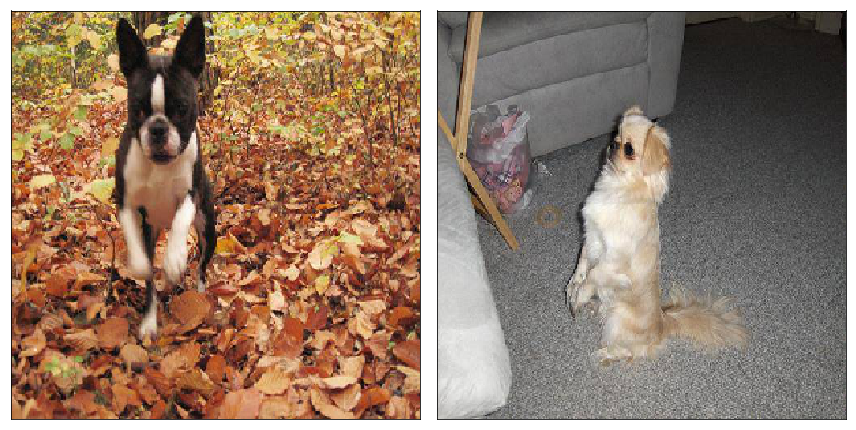

In [154]:
def plotImages( images_arr, n_images=2):
    fig, axes = plt.subplots(1, n_images,  figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
plotImages(x_train_raw[0:2,]/255.)

In [ ]:
def dataaug(image_to_test):
    datagen = ImageDataGenerator()
    temp = np.zeros((2,im_size,im_size,3),dtype=np.float32)
    #image_to_test = 11
    resize_factor=0.8
    for i in range(2):
        if random.randint(1,101) < 50: 
            flip_horizontal = True
        else:
            flip_horizontal = False
        if random.randint(1,101) < 50: 
            flip_vertical = True
        else:
            flip_vertical = False
        if random.randint(1,101) < 20: 
            tx = im_size*resize_factor/100.0
        else:
            tx = -im_size*resize_factor/100.0
        if random.randint(1,101) < 20:
            ty = im_size*resize_factor/100.0
        else:   
            ty = -im_size*resize_factor/100.0
        shear = random.randint(1,10)/100.0
        zx = random.randint(80,120)/100.0
        zy = random.randint(80,120)/100.0
        brightness = random.randint(1,2)/100.0
        channel_shift_intensity = random.randint(1,10)/100.0
    
        temp[i] = datagen.apply_transform(x_train_raw[image_to_test],{
            'tx':tx,
            'ty':ty,
            'shear':shear,
            'zx':zx,
            'zy':zy,
            'flip_horizontal':flip_horizontal,
            'flip_vertical':flip_vertical,
            #'brightness':brightness,
            #'channel_shift_intensity':channel_shift_intensity
            })
    plotImages(temp[0:2,]/255.0)

In [ ]:
dataaug(10)